#**Coluna fracionamento - MESH - Solução incremental - Condensador total**

Mariana Lima de Almeida - Engenharia Química / FAT - UERJ

Este script tem como objetivo simular o processo de destilação nas seguintes condições:
* Pressão constante;
* Coluna adiabática;
* Misturas ideais;
* Utilizando condensador total;
* Utilizando refervedor parcial;
* Apenas uma corrente de alimentação;
* Corrente de saída apenas no topo e no fundo


A modelagem matemática segue a solução das equações MESH e utiliza o procedimento ponto de bolha para solução, este sendo próprio para misturas ideais

#**Algoritmo de funcionamento do simulador**

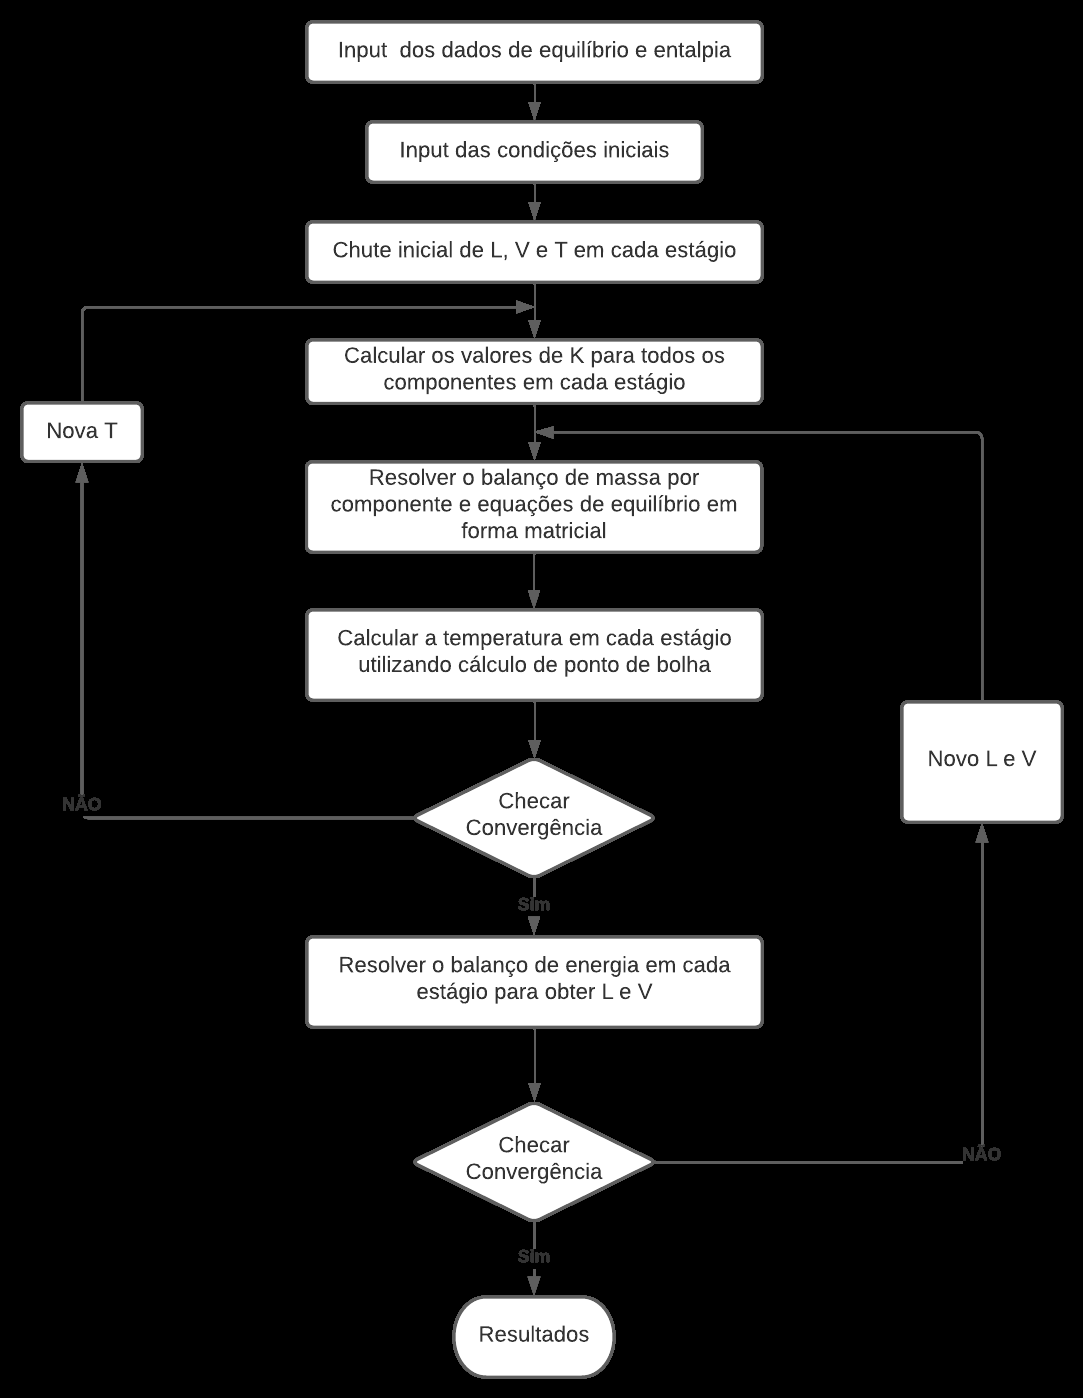

#**Preparo inicial - Inserção dos dados da simulação desejada**

In [20]:
# Preparando kernel
import pandas as pd
!pip3 install pickle5
import pickle5 as pickl
import numpy as np
import matplotlib.pyplot as plt
# Carregamento das funções úteis
from OU3_funcoes_uteis_v02 import *
# Para ler/carregar
with open('databank_properties.pickle', 'rb') as handle:
    dados, all_units = pickl.load(handle)

**Seleção dos componentes do sistema**


Você deverá procurar o nome do componente desejado e anotar o número corresponde a primeira coluna [num]

In [21]:
dados[dados.name.str.contains('toluene', case = False)]

,num,name,molar_mass,fusion_point,boiling_point,critical_temp,critical_pressure,critical_volume,zc,acentric_factor,...,pvap_a,pvap_b,pvap_c,temp_max_pvap,temp_min_pvap,pvap_h_a,pvap_h_b,pvap_h_c,pvap_h_d,delta_h_vap_bp
440,286,TOLUENE,92.141,178.0,383.8,591.7,40.6,316.0,0.264,0.257,...,16.0137,3096.52,-53.67,410.0,280.0,56.785,-6283.5,-5.681,4.84,7930.0


**Inserindo o código dos componentes e nome deles**

Na lista abaixo, inserir o número anotado em ordem crescente (requisito para o funcionamento do simulador).

Insira também o nome dos componentes escolhidos, na mesma ordem

In [22]:
# Seleção dos componentes presentes no sistema (Benzeno, Tolueno e p-Xileno)
lista_componentes = [242, 249, 286, 324]

nome_componente = ['Benzeno','Ciclo-hexano' ,'Tolueno','p-xileno']


Para realizar a simulação, serão necessários fornecer os seguintes dados:

* F = Vazão da corrente de alimentação em mol/s

* z = composição da corrente de aliemntação na ordem dos componentes selecionados

* P = pressão de operação da coluna de destilação em mmHg

* Ti = Temperatura da corrente de alimentação em K

* n = número de estágios teóricos da coluna de destilação, sem considerar o refervedor parcial e o condensador total

* n_alim = estágio de alimentação, considerando a contagem apenas em relação a n, não levando em consideração o condensador

* raz = razão de refluxo do condensador total

* D = Vazão da corrente de destilado

In [23]:
F = 100 # mol/s 
z = [0.4,0.2,0.2,0.2] 
P = 760 # mmHg
Ti = 374 # k
n = 10
n_alim = 5 # estágio em relação somente à coluna, sem considerar condensador e refervedor 
raz = 2 # razão de refluxo 
D = 60 # vazão de destilado

A temperatura da corrente de alimentação deve estar entre as duas abaixo, uma vez que o modelo é apenas para correntes que estão localizadas entre o ponto de bolha e o de orvalho

In [24]:
verificar_T = f_calculo_PbPo_db('T', P, z, lista_componentes, dados)[:2] # usar no meio
verificar_T

(364.8604166635893, 380.4071925619178)

In [25]:
if Ti < verificar_T[1] and Ti > verificar_T[0]:
  print('Tudo certo para a simulação')
else:
  exit()


Tudo certo para a simulação


**A PARTIR DE AGORA É SÓ ESPERAR O TEMPO DA SIMULAÇÃO E VER OS RESULTADOS LOGO ABAIXO**

# **SIMULAÇÃO**

###**Definições iniciais**

In [26]:
B = F - D # vazão de destilado
j = n + 2 # esse dois a mais é o reboiler e o condensador
nc = len(lista_componentes) # número de componentes no sistema

###**Cálculo da volatilidade - K**

In [27]:
# Verificando os pontos de ebulição de nossos componentes 
T_eb_comp = dados[dados['num'].isin(lista_componentes)]['boiling_point']
T_eb_comp = T_eb_comp.tolist()
T_eb_comp

[353.3, 353.9, 411.5, 383.8]

In [28]:
# Calculo dos valores de K
K_comp = f_K_Raoult_db(T_eb_comp[0], 760, lista_componentes, dados)[0]
K_comp

array([1.0014828 , 0.9827098 , 0.38515955, 0.15506167])

In [29]:
# Identificação do menos volátil - componente chave pesado
i_chk = np.argmin(K_comp)
i_chk

3

##**Balanço de massa por componente -> Forma matricial**

#### Cálculo Flash utilizando Rachford-Rice

In [30]:
flash = f_sol_RR_flash_db(z, P, Ti, lista_componentes, dados)
flash

{'K_comp': array([1.8181506 , 1.76332685, 0.75105628, 0.32552261]),
 'alpha_comp': array([5.58532809, 5.41691042, 2.30723226, 1.        ]),
 'fv_flash': 0.6833830018050671,
 'x_eq': array([0.25655659, 0.13143674, 0.24099983, 0.37100684]),
 'y_eq': array([0.46645852, 0.23176593, 0.18100444, 0.12077112])}

In [31]:
fv_flash = flash['fv_flash']
fv_flash

0.6833830018050671

**Cálculo da qualidade da carga**

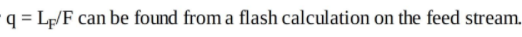

In [32]:
Lf = F - (fv_flash*F)
Lf

31.661699819493293

In [33]:
Vf = F - Lf

In [34]:
q = Lf/F
q 

0.31661699819493294

A qualidade da carga é um valor fixo, uma vez que depende apenas do input da carga no sistema

####**Chute inicial para as vazões e temperaturas**

Considerações para esse chute inicial:

* fluxo molar constante para a estimativa inicial;
* O componente leve sai todo no destilado; 
* O componente pesado sai no fundo

Consideração minha para separação de N componentes:

O componente mais leve irá sair todo no topo e o mais pesado todo no fundo. 

Em relação ao restante dos componentes, iremos tomar 1 como parâmetro. Se for maior que 1 irá para o topo e se for menor, irá para o fundo.

#### Vazões:

In [35]:
i_leve = np.argmax(K_comp)

In [36]:
# Primeiro precisamos criar um vetor apenas com os componentes intermediários, isso irá facilitar a lógica depois

# Vamos criar um vetor novo de cópia e retirar o componente leve ou pesado que estiver mais no final da lista e depois retirar o outro, de forma que a posição do segundo a ser retirado não seja alterada

lista_componentes_NK = lista_componentes.copy() # coloquei o copy por que sem ele aaltera o nome para o antigo

if i_leve > i_chk: 
  lista_componentes_NK.pop(i_leve)
  lista_componentes_NK.pop(i_chk)

else:
  lista_componentes_NK.pop(i_chk)
  lista_componentes_NK.pop(i_leve)

lista_componentes_NK    

[249, 286]

####Vazões de líquido e vapor na seção de retificação

Valores do estágio de alimentação

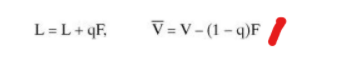

In [37]:
L = raz*D # mol/s 
V = L + D # mol/s 

In [38]:
# Valores na alimentação
L_alim = L + q*F 
V_alim = V - (1-q)*F 

Vamos manter o chute dessa forma

In [39]:
# Esse vetor deverá ser criado com o número de estágios + condensador e refervedor, de forma que o primeiro item do vetor seja 0 pois no condensador não existe vapor

V_chute = [0] # já começando com o valor inicial certinho

k = 0
while k < n_alim: # vai fazer o preenchimento até chegar na alimentação
  V_chute.append(V_alim)
  k +=1

while k != j-1: # vai fazer o preenchimento até chegar o final, partindo da alimentação
  V_chute.append(V)
  k +=1

k=0 # apenas limpando o k por que eu uso muito e por um descuido ele pode entrar com valor depois

V_chute

[0,
 111.6616998194933,
 111.6616998194933,
 111.6616998194933,
 111.6616998194933,
 111.6616998194933,
 180,
 180,
 180,
 180,
 180,
 180]

####**Função para Calcular L a partir de V**

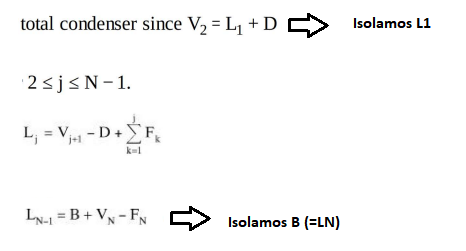

In [40]:
def L(D,B,n_alim,V,F):                             

  L_calc = []

  L_calc.append(V[1] - D) # L1
  

  cont = 1
  while cont <(n_alim): # para completar até o estágio de alimentação
    L_calc.append(V[cont+1] - D)
    cont +=1

  L_calc.append(V[n_alim+1] - D + F ) # no estágio de alimentação
  #L_calc.append(L_calc[cont-1] + ( V[cont]) - V[cont-1] + F*q)

  cont +=1
  while cont <(j-1): # para completar após o estágio de alimentação
    L_calc.append(V[cont+1] - D + F) # É só F msm, devido ao balanço    
    #L_calc.append(L_calc[n_alim]) # É só F msm, devido ao balanço 
    cont +=1

  #L_calc.append(L_calc[j-2] - V[j-1]) # Reboiler
  L_calc.append(B)

  L_calc = np.array(L_calc)
  return L_calc

In [41]:
L_chute = L(D,B,n_alim,V_chute,F)
L_chute

array([ 51.66169982,  51.66169982,  51.66169982,  51.66169982,
        51.66169982, 220.        , 220.        , 220.        ,
       220.        , 220.        , 220.        ,  40.        ])

####**Temperaturas e k:**

Um melhor chute inicial pode ser obtido ao estimar as composições no destilado e no fundo e fazer cálculos de ponto de bolha para ambos. Então assumir que a temperatura varia linearmente de estágio para estágio.

In [42]:
# Será necessário criar um Z_topo e um Z_fundo de acordo com a divisao feita para a corrente de B e D
z_topo = []
z_fundo = []

# Irei fazer uma verificação em cada um dos itens da lista para inserir corretamente o chave leve no topo, o pesado no fundo e os outros nos locais baseado no k> ou <1

k = 0
gu = len(z)
z_num = list(range(0,gu,1))

for i in z_num:

  if i == i_chk:
    z_topo.append(0)
    z_fundo.append(1)

  elif i == i_leve:
    z_topo.append(1)
    z_fundo.append(0)

  elif K_comp[k] > 1:
    z_fundo.append(0)
    z_topo.append(1)

  else:
    z_fundo.append(1)
    z_topo.append(0) 

  k += 1 


k = 0 # limpando ele 

In [43]:
# Verificando a distribuição dos componentes em topo e fundo 

z_topo # correto, apenas o benzeno sai no topo

[1, 0, 0, 0]

In [44]:
z_fundo

[0, 1, 1, 1]

In [45]:
z_topo = [1,0,0,0]
z_fundo = [0,1/3,1/3,1/3]

In [46]:
# Ponto de bolha no topo da coluna
Tb1 = f_calculo_PbPo_db('T',P,z_topo,lista_componentes,dados) # [1,0] -> composição estimada no topo da coluna [Benzeno,Tolueno] no chute inicial para CMO
Tb1 = Tb1[0] # [0] é ponto de bolha e [1] é o ponto de orvalho
Tb1

353.2518852359842

In [47]:
# Ponto de bolha no fundo da coluna
TbN = f_calculo_PbPo_db('T',P,z_fundo,lista_componentes,dados) # [0,1] -> composição estimada no topo da coluna no chute inicial para CMO
TbN = TbN[0] # [0] é ponto de bolha e [1] é o ponto de orvalho
TbN

375.95383346407425

In [48]:
# Ponto de bolha na alimentação
Tb_alim = f_calculo_PbPo_db('T',P,z,lista_componentes,dados) # composição da alimentação
Tb_alim = Tb_alim[0] # [0] é ponto de bolha e [1] é o ponto de orvalho
Tb_alim

364.8604166635893

Considerando que a temperatura varia linearmente a partir do estágio de alimentação:

In [49]:
T_chute_pt1 = np.linspace(Tb1,Tb_alim,n_alim) # j = n+1 = 13 + 1 = 14 -> o 1 a mais é o reboiler
T_chute_pt1 
# A temperatura diminui ao longo da coluna

array([353.25188524, 356.15401809, 359.05615095, 361.95828381,
       364.86041666])

In [50]:
T_chute_pt2 = np.linspace(Tb_alim,TbN,j-n_alim+1) #
T_chute_pt2 = T_chute_pt2[1:]
T_chute_pt2
# A temperatura diminui ao longo da coluna

array([366.44519049, 368.02996432, 369.61473815, 371.19951198,
       372.78428581, 374.36905964, 375.95383346])

In [51]:
T_chute = np.concatenate((T_chute_pt1,T_chute_pt2))
T_chute

array([353.25188524, 356.15401809, 359.05615095, 361.95828381,
       364.86041666, 366.44519049, 368.02996432, 369.61473815,
       371.19951198, 372.78428581, 374.36905964, 375.95383346])

**K:**

In [52]:
k_chute = []

for i in T_chute:  
  k = (f_K_Raoult_db(i,P,lista_componentes,dados)) # i é a própria temperatura de equilíbrio  
  k_chute.append(k[0]) # retorna k (dos dois componentes) e P_vap
                           # k[0] para retirar apenas a parte da resposta do k, k[1] = P_vap

In [53]:
k_chute

[array([1.        , 0.98128388, 0.3845208 , 0.15477586]),
 array([1.09256911, 1.07022925, 0.42460794, 0.17280941]),
 array([1.1917089 , 1.16533323, 0.46799134, 0.19253478]),
 array([1.29772975, 1.2668769 , 0.51486347, 0.21406966]),
 array([1.4109475 , 1.37514584, 0.56542256, 0.2375366 ]),
 array([1.47592541, 1.43721112, 0.59466071, 0.25121229]),
 array([1.54319794, 1.50141588, 0.62509293, 0.26552343]),
 array([1.6128184 , 1.56780817, 0.65675363, 0.28049181]),
 array([1.68484052, 1.63643635, 0.68967771, 0.29613969]),
 array([1.75931842, 1.70734908, 0.72390053, 0.31248975]),
 array([1.83630659, 1.78059535, 0.75945794, 0.32956512]),
 array([1.91585989, 1.8562244 , 0.79638626, 0.34738934])]

####**Cálculo das variáveis A,B,C,D para cada componente**

Como existem formas de cálculo diferenciadas para o cálculo do condensador total, estágio de alimentação e reboiler em relação aos demais estágios, será criada uma função para facilitar estes cálculos

In [54]:
# Função apenas para armazenar os valores, depois será criada outra para ordenar eles corretamente na matriz
# Sairá os valores para os dois componentes

def variavel_matriz_i(i,k,V,L,n_aliment,j,D,F,z): # n_aliment = estágio de alimentação, j é o número de estágios(contando com o reboiler)
# i é o componente desejado para o cálculos das variáveis
  A = []
  B = [1 + D/L[0],]
  C = []
  D = []

  # J = 1 -> condensador total
  A.append(0)
  #B.append(1 + D/L[0]) -> por algum motivo divino não calcula aqui, mas calcula direto lá no B
  C.append(-k[1][i]*V[1]/L[1])
  D.append(0) # não tem alimentação

  # J = 2 até a alimentação 
  u = 1 # corresponde ao segundo estágio, j = 2 (topo da coluna)
  lim_sup1 = n_aliment # por causa da indexação em python começar em 0, vai parar no nível anterior da alimentação -> + condensador, fica certo só assim
  
  while u<lim_sup1: # irá preencher os estágio até a alimentação
    A.append(-1) # todos os A são -1
    B.append(1 + V[u]*k[u][i]/L[u])
    C.append(-V[u+1]*k[u+1][i]/L[u+1])
    D.append(0) # como não tem alimentação, D=0 em todos esses estágios
    u +=1

  # J = alimentação
  A.append(-1)
  B.append(1 +V[n_aliment]*k[n_aliment][i]/L[n_aliment])
  C.append(-k[n_aliment+1][i]*V[n_aliment+1]/L[n_aliment+1])
  D.append(F*z[i])

  # J = alimentação até o reboiler
  v = n_aliment + 1  # corresponde ao primeiro estágio acima da alimentação (não tem o +1 devido a indexação) -> tem o mais 1 devido ao acréscimo do condensador
  
  while v<(j-1): # irá preencher os estágio até a alimentação
    A.append(-1) # todos os A são -1
    B.append(1 + V[v]*k[v][i]/L[v])
    C.append(-V[v+1]*k[v+1][i]/L[v+1])
    D.append(0) # como não tem alimentação, D=0 em todos esses estágios
    v +=1    

  # Reboiler 
  A.append(-1)
  B.append(1 + V[j-1]*k[j-1][i]/L[j-1]) # j-1 devido a indexação
  C.append(0)
  D.append(0)

  return A,B,C,D



**Variáveis para a matriz - Loop para cada um dos componentes**

In [55]:
var_componentes_mtx = []
k = 0

for item in z:
  asp = variavel_matriz_i(k,k_chute,V_chute,L_chute,n_alim,j,D,F,z)
  var_componentes_mtx.append(asp)
  k += 1

k = 0 # apenas limpando

In [56]:
var_componentes_mtx[0] # apenas verificando o formato do primeiro item, o restante dos componentes estão na lista e seguem o mesmo padrão


([0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
 [2.161401971085753,
  3.361481025859699,
  3.575761970233188,
  3.8049156456791873,
  4.049624706788062,
  1.749110637506754,
  2.262616495846018,
  2.319578692575953,
  2.3785058837337747,
  2.4394423467875863,
  2.502432667799461,
  9.621369511484385],
 [-2.361481025859699,
  -2.575761970233188,
  -2.8049156456791873,
  -3.0496247067880624,
  -0.749110637506754,
  -1.2626164958460178,
  -1.319578692575953,
  -1.3785058837337747,
  -1.4394423467875863,
  -1.502432667799461,
  -8.621369511484385,
  0],
 [0, 0, 0, 0, 0, 40.0, 0, 0, 0, 0, 0, 0])

####**Algoritmo de Thomas para matriz tridiagonal**

In [57]:
def TDMA(a,b,c,d):  
   # preliminares  
    a = a.astype('double')  
    b = b.astype('double')  
    c = c.astype('double')  
    d = d.astype('double')  
 
    #recupera ordem do sistema  
    n=np.shape(a)[0]  
 
    #inicializa vetores auxiliares  
    cl=np.zeros(n)  
    dl=np.zeros(n)  
    x=np.zeros(n)  
 
    #calcula cl e dl  
    cl[0]=c[0]/b[0]  
    for i in np.arange(1,n-1,1):  
       cl[i]=c[i]/(b[i]-a[i]*cl[i-1])  
 
    dl[0]=d[0]/b[0]  
    for i in np.arange(1,n,1):  
       dl[i]=(d[i]-a[i]*dl[i-1])/(b[i]-a[i]*cl[i-1])  
 
    #faz substituicao reversa para obter a solucao x  
    x[n-1]=dl[n-1]  
    for i in np.arange(n-2,-1,-1):  
       x[i]=dl[i]-cl[i]*x[i+1]  
 
    return x  

https://www.ufrgs.br/reamat/CalculoNumerico/livro-py/sdsl-metodo_da_matriz_tridiagonal.html

Retorna a solução do sistema, nossa fração de líquido do componente $l_{i,j}$

A função requer que as entradas sejam da forma np.array


In [58]:
var_componentes_mtx_np = np.array(var_componentes_mtx)

Aplicando o algoritmo de Thomas em cada um dos componentes e armazenando em um único array

In [59]:
l_componentes = []

k = 0

for item in var_componentes_mtx_np:
  val = TDMA(var_componentes_mtx_np[k][0],var_componentes_mtx_np[k][1],var_componentes_mtx_np[k][2],var_componentes_mtx_np[k][3])
  l_componentes.append(val)
  k+=1

k = 0

In [60]:
# Verificando o formato do primeiro componente da lista

l_componentes[0]

array([33.25920797, 30.44128531, 26.81482055, 23.33122935, 20.31677501,
       78.68541942, 61.23215511, 45.36255786, 31.91126572, 21.21555996,
       13.20716068,  1.37269031])

####**Calculo dos valores normalizados de vazão por componente em cada estágio -> x** (FRAÇÕES MOLARES)

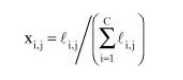

In [61]:
def x_matriz(lista): # lista = array da saída da função de cálculo por Thomas para cada componente do sistema (lista de listas)

  n = len(lista) # comprimento da lista -> número de componentes do sistema

  x_componente = [] # vetor que irá abrigar oas frações molares

  for i in lista:
    x_componente.append([]) # criando um local vazio para a fração molar de cada um dos componentes



  # Fazendo um somatório inicial de todos os componentes em cada posição i, será utilizada na divisão e podemos chamar apenas a posição desejada 
  divisor = [] 

  k = 0
  for estagio in lista[0]:
    somatorio = 0

    for componente in lista:
      somatorio += componente[k]

    divisor.append(somatorio) # já validei esse somatório, ele está somando certinho 
    k+=1
    # agora temos o valor do dividendo em cada um dos estágios

# Para cada componente puxar o i dele dividindo pelo i do somatório (dentro for item in lista inserir o while)
# logo depois inserir no append (estilo x_componente[k].append(comp), itera com cada componente) o valor do x daquele componente em seu respectivo estágio
  i = 0 # indexação começa em 0 -> itera os estágios
  p = 0 # para iterar o local destino da fração molar de cada um dos componentes ao longo dos estágios

  estagio = len(lista[0]) # apenas resgatando o número de estágios a partir do comprimento da lista do primeiro componente


  for item in lista:

    i=0 # zerando para quando começar um novo componente
    while i < estagio: # o ultimo será estagio - 1 : correta indexação
      x_local = lista[p][i]/divisor[i]
      
      x_componente[p].append(x_local)

      i +=1
    p +=1

  return(x_componente)




In [62]:
x_calculado = x_matriz(l_componentes)
x_calculado # Condensador -> reboiler

[[0.6396407432756019,
  0.593839594938404,
  0.5488599690303803,
  0.5063408094962619,
  0.46622999558325673,
  0.42524332970777334,
  0.37342517079771637,
  0.3093647179186079,
  0.23548379305586845,
  0.1580085462602807,
  0.0868175778561599,
  0.03465433181693538],
 [0.3174489805844318,
  0.3008701267283796,
  0.28112317722596625,
  0.2607926651083069,
  0.24079012658380264,
  0.21976599224444832,
  0.1977603941798072,
  0.1679930227130068,
  0.13119239179102746,
  0.09036350502011577,
  0.05100265897279375,
  0.020942483725773474],
 [0.04211077862735074,
  0.10059748217591101,
  0.15580985377164575,
  0.1980459832212917,
  0.21910692938949158,
  0.21649825509462306,
  0.26952352539130553,
  0.3393513071459015,
  0.422433105595892,
  0.5003278610587805,
  0.5260013426819394,
  0.44071091707036614],
 [0.0007994975126154637,
  0.004692796157305473,
  0.014206999972007814,
  0.03482054217413943,
  0.07387294844344906,
  0.13849242295315528,
  0.1592909096311708,
  0.1832909522224837,
 

Verificando se o somatório é 1

In [63]:
k=0 # representa o componente
for estag in x_calculado[0]:
  somat = 0

  for component in x_calculado:
    somat += component[k]
  
  k+=1
  print(somat)

 # A partir do resultado em print, podemos verificar que o somatório é 1 ou praticamente 1.

0.9999999999999999
1.0000000000000002
1.0
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
1.0
1.0000000000000002


####**Cálculo da temperatura em cada estágio a partir do cálculo de ponto de bolha**

In [64]:
# Ponto de bolha em cada estágio
e = 0 # contador de estágios para a referência na hora de montar o vetor composição
Tb_new = []

for i in x_calculado[0]: # vai iterar em cada um dos estágios

  z_estagio = [] # a cada iteraçao iremos preencher esse z
  compound = 0

  for c in x_calculado:
    z_estagio.append(x_calculado[compound][e])
    compound+=1 # o z está saindo certinho, com somatório =1 em cada estágio


  Tb = f_calculo_PbPo_db('T',P,z_estagio,lista_componentes,dados) # [a,b] -> composição no estágio analisado
  Tb = Tb[0] # [0] é ponto de bolha e [1] é o ponto de orvalho
  Tb_new.append(Tb)
  e +=1

Tb_new

[354.33440648000476,
 355.68313013274775,
 357.1920149669896,
 358.83225603608287,
 360.67204722943694,
 362.9441410602715,
 365.23749875252736,
 368.3629919789827,
 372.43557981491074,
 377.53497342746044,
 383.9289106647822,
 391.9533428653125]

OBS: A temperatura no estágio de alimentação realmente vai variar ao longo das iterações

####**Cálculo do novo valor de k**

In [65]:
k_new = []

for i in Tb_new:  
  k_prov = (f_K_Raoult_db(i,P,lista_componentes,dados)) # i é a própria temperatura de equilíbrio  
  k_new.append(k_prov[0]) # retorna k (dos dois componentes) e P_vap
                           # k[0] para retirar apenas a parte da resposta do k, k[1] = P_vap

####**Cálculo de y**

$y = k \cdot x $

In [66]:
def y_matriz(k,x_calculado): # lista = array da saída da função de cálculo por Thomas para cada componente do sistema (lista de listas)

  n = len(x_calculado) # comprimento da lista -> número de componentes do sistema

  y_componente = [] # vetor que irá abrigar oas frações molares

  for i in x_calculado:
    y_componente.append([]) # criando um local vazio para a fração molar de cada um dos componentes

  i = 0 # indexação começa em 0 -> itera os estágios
  p = 0 # para iterar o local destino da fração molar de cada um dos componentes ao longo dos estágios

  estagio = len(k) # apenas resgatando o número de estágios a partir do comprimento da lista do primeiro componente

  for item in x_calculado:

    i=0 # zerando para quando começar um novo componente
    while i < estagio: # o ultimo será estagio - 1 : correta indexação
      y_local = (x_calculado[p][i])*(k[i][p])
      
      y_componente[p].append(y_local)

      i +=1
    p +=1

  return(y_componente)


In [67]:
y_calculado = y_matriz(k_new,x_calculado)
y_calculado

[[0.6612479295959746,
  0.6396310121520365,
  0.6187064277142146,
  0.5994161103631537,
  0.582727707671136,
  0.5678558276654259,
  0.532580163681529,
  0.4818762225867373,
  0.41038164881554745,
  0.3156761192043601,
  0.204638303369535,
  0.09964193867353299],
 [0.3218166833005143,
  0.3175341544931124,
  0.31022584695874006,
  0.301938050953908,
  0.29401909274442795,
  0.28633031513554363,
  0.2748320234098904,
  0.25454043033887236,
  0.22191813049772063,
  0.17477241367665133,
  0.11601836489515512,
  0.05789602992219954],
 [0.016806418597109185,
  0.042038130772170564,
  0.06851523652356965,
  0.09199685191732204,
  0.108161376119295,
  0.115093685033671,
  0.15424105346728995,
  0.21434889900731446,
  0.30257068700740636,
  0.41758999750175685,
  0.5282911876561875,
  0.5528807593541615],
 [0.0001289685064018836,
  0.0007967025826809963,
  0.0025524888041884393,
  0.00664898676580905,
  0.0150918234651801,
  0.030720172165364032,
  0.03834675944129027,
  0.049234448067076025,


verificando se so somatório é 1

In [68]:
k=0 # representa o componente
for estag in y_calculado[0]:
  somat = 0

  for component in y_calculado:
    somat += component[k]
  
  k+=1
  print(somat)

 # A partir do resultado em print, podemos verificar que o somatório é 1 ou praticamente 1.

0.9999999999999999
1.0000000000000004
1.0000000000007128
1.0000000000001927
1.000000000000039
1.0000000000000044
0.9999999999999998
1.0000000000000002
1.000000000000485
0.9999999999999996
1.0000000000000175
0.9999999999992097


Somatório de y = 1 em todos os estágios -> correto

####**Erro entre o chute inicial de T e o calculado -> Critério de parada**

$|T_{j,new} - T_{j,old}| < tol_T$

In [69]:
tol_T = 10**(-2) # Valor recomendado pelo livro

In [70]:
Dif_T = abs(Tb_new - T_chute)
Dif_T

array([ 1.08252124,  0.47088796,  1.86413598,  3.12602777,  4.18836943,
        3.50104943,  2.79246557,  1.25174617,  1.23606784,  4.75068762,
        9.55985103, 15.9995094 ])

####**Inserindo o loop para convergência de temperatura**

In [71]:
def loop_T(L_chute,V_chute,Tb_old,k_old,n_alim,F,j,D,z,P,lista_componentes,dados,erro):
  iteracao = 0 # para verificar depois quantas iterações ele fez
  g = 0 # será atualizado na verificação da tolerância
  
  while g!=j: # enquanto a verificação de convergencia não bater com a quantida de estágios que devem convergir

  # Grantindo que k_old e T_old vão atualizar após a primeira iteração

    if iteracao == 0:
      k_old_i = k_old
      Tb_old_i = Tb_old # parece que realmente não usei isso kkk pq crio no tb_novo depois
    else:
      k_old_i = k_old_att
      Tb_old_i = Tb_old_att

    # variáveis de todos os componentes dentro de um único vetor

    var_componentes_mtx = []
    k = 0

    for item in z:
      asp = variavel_matriz_i(k,k_old_i,V_chute,L_chute,n_alim,j,D,F,z)
      var_componentes_mtx.append(asp)
      k += 1

    k = 0 # apenas limpando

      # Algoritmo de Thomas

    var_componentes_mtx_np = np.array(var_componentes_mtx) # colocando em um array numpy como o algoritmo requer

    l_componentes = []

    for item in var_componentes_mtx_np:
      val = TDMA(var_componentes_mtx_np[k][0],var_componentes_mtx_np[k][1],var_componentes_mtx_np[k][2],var_componentes_mtx_np[k][3])
      l_componentes.append(val)
      k+=1

    k = 0

      # Cálculo de x
    x_calculado = x_matriz(l_componentes)

      # Cálculo da nova temperatura

    e = 0 # contador de estágios para a referência na hora de montar o vetor composição
    Tb_novo = [] # mudei de T_new para esse direto por que depois iria referenciar o tb_new de entrada

    for i in x_calculado[0]: # vai iterar em cada um dos estágios

      z_estagio = [] # a cada iteraçao iremos preencher esse z
      compound = 0

      for c in x_calculado:
        z_estagio.append(x_calculado[compound][e])
        compound+=1 # o z está saindo certinho, com somatório =1 em cada estágio


      Tb = f_calculo_PbPo_db('T',P,z_estagio,lista_componentes,dados) # [a,b] -> composição no estágio analisado
      Tb = Tb[0] # [0] é ponto de bolha e [1] é o ponto de orvalho
      Tb_novo.append(Tb)
      e +=1

      # Cálculo do novo valor de k
    k_novo = []

    for i in Tb_novo:  
      k = (f_K_Raoult_db(i,P,lista_componentes,dados)) # i é a própria temperatura de equilíbrio  
      k_novo.append(k[0])

      # Cálculo de y:
    y_calculado = y_matriz(k_novo,x_calculado)

      # Cálculo da convergência de temperatura:
    Dif_T = abs(np.array(Tb_novo) - np.array(Tb_old_i))
    result = Dif_T<tol_T # array que retorna True ou False para a condição de ser menor que a tolerância
  
    for i in result: 
      if i ==False:
        g += 0 
      if i ==True:
        g+=1

    if g!=j:
      g = 0  # Para limpar ele para uma nova iteração

    #tb_old_att = Tb_old_i + (Tb_novo - Tb_old_i)

    Tb_old_att = Tb_novo # atualizando o valor para a nova iteração
    k_old_att = k_novo   # atualizando o valor para a nova iteração
    
    iteracao +=1 # atualizando o contador de loops realizados

  Tb_final = Tb_old_att # retorna o último valor atualizado
  k_final = k_old_att

  return iteracao,Tb_final,k_final,x_calculado,y_calculado,Dif_T,result


####**Resolvendo o nosso loop para encontrarmos T, x e y**

In [72]:
sol_T = loop_T(L_chute,V_chute,Tb_new,k_new,n_alim,F,j,D,z,P,lista_componentes,dados,tol_T)

**Número de iterações utilizadas:**

In [73]:
sol_T[0] 

22

**Erro encontrado:**

In [74]:
sol_T[5]

array([0.00030268, 0.00073614, 0.00116806, 0.00153868, 0.00177147,
       0.00174488, 0.00373165, 0.00652347, 0.00879967, 0.00878962,
       0.00653853, 0.00371344])

**Verificação de que todos os pontos estão dentro da tolerância desejada:**

In [75]:
sol_T[6]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

**Perfil de temperatura:**

In [76]:
T_converg = sol_T[1]
T_converg

[354.03440359944614,
 354.9390666002821,
 355.9975717663491,
 357.2761587567018,
 358.96528736702305,
 361.4420917404958,
 363.24151781167035,
 366.5366062566626,
 371.6503578770559,
 378.1643767234475,
 385.2880685067863,
 392.6231090250135]

**x em cada estágio:**

In [77]:
x_converg = sol_T[3]
x_converg

[[0.6490504615399808,
  0.6163622801689181,
  0.5829674311904637,
  0.5472732977308956,
  0.5064894978759813,
  0.45613002335205527,
  0.4095449094979774,
  0.334300903252399,
  0.23609982763883516,
  0.13919345025598728,
  0.0673530494983902,
  0.026180147005253323],
 [0.3225053420651642,
  0.3124266886531441,
  0.29836534389609826,
  0.281433124084771,
  0.2611326384866643,
  0.23560413918454212,
  0.2164128028325091,
  0.18106786437375852,
  0.1314332669076687,
  0.07989127249095333,
  0.03998005364713035,
  0.01612188679072393],
 [0.028056159660157103,
  0.06886016911868849,
  0.1111225382381445,
  0.15076958305114557,
  0.181808709536314,
  0.195921936962896,
  0.25654688237314066,
  0.35512200451277226,
  0.47513185202042824,
  0.563258164593147,
  0.5620605253458654,
  0.45808432845997293],
 [0.00038803673469785027,
  0.0023508620592492444,
  0.00754468667529349,
  0.020523995133187953,
  0.0505691541010404,
  0.11234390050050652,
  0.11749540529637281,
  0.12950922786107025,
  

**y em cada estágio:**

In [78]:
y_converg = sol_T[4]
y_converg

[[0.6648420837477226,
  0.6490504184231972,
  0.6339270337909191,
  0.6184771379194987,
  0.6019638799529764,
  0.5830961578786025,
  0.5516097600987524,
  0.49467944606194975,
  0.4027334507597245,
  0.2827317829096206,
  0.16430370929091814,
  0.07650260297855832],
 [0.3240134050728002,
  0.3225054647715598,
  0.31784260063063186,
  0.31133726414441204,
  0.3035038681543143,
  0.2941122386217743,
  0.2843455604562847,
  0.2608927344777871,
  0.21770282729801907,
  0.15704947669513633,
  0.09406041308178313,
  0.04528196704120871],
 [0.011082627759083646,
  0.028056082226445265,
  0.0469342249755211,
  0.06648656896170035,
  0.0848285175300181,
  0.0991879649256974,
  0.137702174729552,
  0.21178886012642342,
  0.33225014689626137,
  0.47891338796115174,
  0.5866226030806716,
  0.5851650414995511],
 [6.18834203929013e-05,
  0.0003880345787981101,
  0.0012961406046607955,
  0.003699028975053404,
  0.009703734362862352,
  0.023603638573944468,
  0.026342504715414775,
  0.032638959333839

##**Balanço de energia na forma matricial**

**Objetivo:** Corrigir os valores de V e L a partir da conversão de T, x e y

Abaixo temos um sistema composto por um balanço global 

###**Cálculo de entalpia**

Criando uma função baseada na função (f_gera_dados_diag_H_ps(P_eq, npg, lista_componentes,dados)) da contribuição do método de Ponchon-Savarit, mas inserindo os valores de T, x e y encontrados anteriormente

In [79]:
def f_gera_dados_H(P_eq, j, lista_componentes,dados,x_converg,y_converg,T_converg,componente_prov): # componente: dizer se é do [0] ou [1] -> tanto faz, se der certo eu tiro essa variável
    '''Função que gera o dataframe com os dados para a serem utilizados nos cálculos dos componentes da matriz de BEG
        Entrada:
        P_eq = pressão de equilíbrio em mmHg
        npg = quantidade de pontos gerados -> será o nosso j
        lista_componentes = 
        dados = 
        Saida:
        dados_ps = dataframe com os dados para calcular as variáveis da matriz tridiagonal para aplicar o método de Thomas
    '''
    dados_ps = pd.DataFrame((T_converg, x_converg[componente_prov],y_converg[componente_prov]),index=['T','x','y']).T # apenas inserindo as temperaturas dos estágios
    dados_ps

    DH_vap_vet = []

    for i, row in dados_ps.iterrows():

        DH_vap_vet.append(f_DHvap_Watson_db(row['T'], lista_componentes, dados)) # Cálculo da Entalpia de vaporização de todos os componentes em cada um dos níveis
        

    # Inserindo uma rotina para criar um vetor com os y de cada componente ao longo dos estágios

    y_estagio = [] # a cada iteraçao iremos preencher esse y
    compound = 0

    for item in y_converg[0]:
      y_estagio.append([]) # criando listas de listas para serem preenchidas em seguida

    componente = 0
    stg = 0

    for c in y_converg: # para cada um dos componentes
      stg = 0 # para limpar para um novo componente
      for estagio in y_converg[0]:
        y_estagio[stg].append(y_converg[componente][stg])
        stg +=1
      componente +=1

    DH_vap = [] # lista a ser preenchida
    it = 0
    for iten in y_converg[0]: # iterando em cada estágio
      DH_vap.append(y_estagio[it] @ DH_vap_vet[it]) # vai calcular tudo de uma vez para cada estágio -> conferi e está correto
      it+=1 
    
    Hig_v = [] # calculando a entalpia da corrente de vapor em cada um dos estágios
    temperatura_i = 0
    for ite in y_estagio:
      Hig_v.append(f_H_vap_ig_stream(ite, 273.15,T_converg[temperatura_i], lista_componentes, dados)[0]) # só isso que eu não verifiquei -> troquei y_estagio pelo ite
      temperatura_i +=1
    
    dados_ps['DH_vap_Watson'] = DH_vap
    dados_ps['Hig_v'] = Hig_v
    dados_ps['Hig_l'] = dados_ps['Hig_v'] - dados_ps['DH_vap_Watson']
    
    return dados_ps

###**Criando um DataFrame com a entalpia das correntes L e V em cada nível**

Será a soma da entalpia de todos os componentes em cada nível separada em L e V

In [80]:
# De forma provisória seguiremos como se ela já fosse o total
H_componentes = f_gera_dados_H(P,j,lista_componentes,dados,x_converg,y_converg,T_converg,0) # o 0 é apenas para indicar um componente para puxar x e y
H_componentes

,T,x,y,DH_vap_Watson,Hig_v,Hig_l
0,354.034404,0.649050,0.664842,30568.069761,7845.740507,-22722.329254
1,354.939067,0.616362,0.649050,30668.994095,7973.107952,-22695.886142
2,355.997572,0.582967,0.633927,30782.658427,8117.899328,-22664.759099
3,357.276159,0.547273,0.618477,30897.172786,8291.567637,-22605.605149
4,358.965287,0.506489,0.601964,30993.311555,8521.866215,-22471.445341
5,361.442092,0.456130,0.583096,31042.725471,8864.849735,-22177.875736
6,363.241518,0.409545,0.551610,31296.520953,9136.569811,-22159.951142
7,366.536606,0.334301,0.494679,31800.632372,9644.242924,-22156.389448
8,371.650358,0.236100,0.402733,32652.981731,10475.174531,-22177.807200
9,378.164377,0.139193,0.282732,33741.022780,11624.663206,-22116.359574


Pegando apenas os dados de interesse

In [81]:
H_tot = pd.DataFrame((H_componentes['T'],H_componentes['Hig_v'],H_componentes['Hig_l']),index = ['T','HV','HL']).T
H_tot

,T,HV,HL
0,354.034404,7845.740507,-22722.329254
1,354.939067,7973.107952,-22695.886142
2,355.997572,8117.899328,-22664.759099
3,357.276159,8291.567637,-22605.605149
4,358.965287,8521.866215,-22471.445341
5,361.442092,8864.849735,-22177.875736
6,363.241518,9136.569811,-22159.951142
7,366.536606,9644.242924,-22156.389448
8,371.650358,10475.174531,-22177.807200
9,378.164377,11624.663206,-22116.359574


### Cálculo da entalpia da corrente de entrada - hF

Calculando da forma mostrada pelo torres, através da entalpia da carga em si e não levando em consideração após o flash:

Necessário calcular:
* Entalpia do vapor saturado na temperatura da carga, utilizando as frações molares obtidas no flash
* Entalpia do líquido saturado na temperatura da carga, utilizando as frações molares obtidas no flash

Cálculo da entalpia de vaporização de todos os componentes na temperatura do flash

In [82]:
H_vap_flash = f_DHvap_Watson_db(Ti, lista_componentes, dados)
H_vap_flash

array([29564.28149221, 28772.58772538, 38357.60827557, 33764.96938413])

Cálculo da entalpia de vaporização da corrente como um todo

In [83]:
H_vap_corrente_flash = flash['y_eq'] @ H_vap_flash
H_vap_corrente_flash

31479.746790840938

Cálculo da entalpia da corrente de vapor

In [84]:
H_vap_flash = f_H_vap_ig_stream(flash['y_eq'], 273.15,Ti , lista_componentes, dados)[0]
H_vap_flash

10797.366257332393

Cálculo da entalpia da corrente de líquido

In [85]:
H_liq_flash = H_vap_flash - H_vap_corrente_flash
H_liq_flash

-20682.380533508545

**Finalmente o cálculo da entalpia da carga de alimentação**

In [86]:
hf = -q*(H_vap_flash - H_liq_flash) + H_vap_flash
hf

830.3433244797616

###**Carga térmica do condensador e do refervedor**

#####**Condensador:**

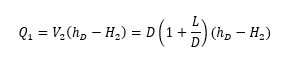

In [87]:
# Entalpia da corrente líquida (benzeno + tolueno) no destilado -> condensador
hd = H_tot['HL'][0] # entalpias líquidas no condensador [0]
hd

-22722.329253800002

In [88]:
# Entalpia da corrente gasosa (benzeno + tolueno) no topo da coluna
H2 = H_tot['HV'][1] # entalpias líquidas no topo da coluna [1]
H2

7973.107952438188

In [89]:
# Finalmente, a carga térmica
Q1 = D*(1+raz)*(hd - H2) # já vem com o valor atualizado de D ao invés de usar V antigo
Q1

-5525178.697122874

#####**Refervedor:**

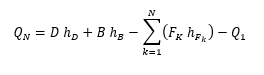

In [90]:
# Entalpia da corrente líquida (benzeno + tolueno) no fundo
hb = H_tot['HL'][j-1] # entalpias líquidas da corrente de saída do reboiler
hb

-20135.663588940944

In [91]:
# somatório, onde k é o prato onde entra alguma corrente e hf é a entalpia do líquido nessa corrente
somat = F*hf
somat

83034.33244797616

In [92]:
# Finalmente, a carga térmica do refervedor
QN = D*hd + B*hb - somat - Q1 # já atualiza os valores
QN

3273378.0658892593

###**Cálculo das variáveis B,C,D para cada componente -> Referente ao BEG**

In [93]:
def variavel_matriz_i_BEG(H_i,Q1,QN,n_aliment,j,vaz_D,vaz_B,F,hf): # n_aliment = estágio de alimentação, j é o número de estágios(contando com o reboiler)
  # vaz_D = D -> por que tem o D vazão e o D lista a ser preenchida  
# H_i é a tabela contendo os dados de entalpia do componente desejado
  B = []
  C = []
  D = []

  # J = 1 -> condensador total
  B.append(0) 
  C.append(H_i['HL'][0] - H_i['HV'][1])
  D.append(Q1) # não tem alimentação no condensador -> F*zi

  # J = 2 até a alimentação 
  #lim_sup = n_aliment - 1 # por causa da indexação em python começar em 0, vai parar no
  lim_sup = n_aliment 
  u = 1 # corresponde ao segundo estágio, j = 2 (topo da coluna)
  
  while u<lim_sup: # irá preencher os estágio até a alimentação
    B.append(H_i['HV'][u] - H_i['HL'][u-1])
    C.append(H_i['HL'][u] - H_i['HV'][u+1])
    D.append(0 + 0 + vaz_D*(H_i['HL'][u-1]) - vaz_D*(H_i['HL'][u])) #- F*H_i['Hig_l'][u] + F*H_i['Hig_l'][u-1]) 
    u += 1 
    
  # J = alimentação
  B.append(H_i['HV'][lim_sup] - H_i['HL'][lim_sup-1])
  C.append(H_i['HL'][lim_sup] - H_i['HV'][lim_sup+1])
  D.append(F*hf + 0 + vaz_D*(H_i['HL'][lim_sup-1]) - vaz_D*(H_i['HL'][lim_sup]) - F*(H_i['HL'][lim_sup])) #+ F*H_i['HL'][n_alim-1]) 
  #D.append(F*hf + 0 + vaz_D*(H_i['HL'][lim_sup-1]) - vaz_D*(H_i['HL'][lim_sup]) + F*(H_i['HL'][lim_sup])*fv_flash) #+ F*H_i['HL'][n_alim-1]) 
  
  # J = alimentação até o reboiler
  v = n_aliment + 1
  
  while v<(j-1): # irá preencher após o estágio de alimentação e antes do reboiler
    B.append(H_i['HV'][v] - H_i['HL'][v-1])
    C.append(H_i['HL'][v] - H_i['HV'][v+1])
    D.append(0 + 0 + vaz_D*(H_i['HL'][v-1]) - vaz_D*(H_i['HL'][v]) - F*(H_i['HL'][v]) + F*(H_i['HL'][v-1]) )  # k é o componente todo

    v += 1

  # Reboiler 
  B.append(H_i['HV'][j-1] - H_i['HV'][j-2]) # j-1 devido a indexação
  C.append(0)
  D.append(0 + QN + vaz_B*(H_i['HL'][j-2]) - vaz_B*(H_i['HL'][j-1]) - 0) # não tem alimentação no reboiler

  #B[-1] = - C[-2]

  return B,C,D

In [94]:
vaz_D = D #
vaz_B = B #

In [95]:
var_BEG = variavel_matriz_i_BEG(H_tot,Q1,QN,n_alim,j,vaz_D,vaz_B,F,hf)

In [96]:
var_BEG

([0,
  30695.437206238188,
  30813.785470076353,
  30956.32673581757,
  31127.471363870856,
  31336.295075721264,
  31314.445547376206,
  31804.194066131306,
  32631.563978331465,
  33802.4704061851,
  35132.726783485785,
  1609.2145174134566],
 [-30695.437206238188,
  -30813.785470076353,
  -30956.32673581757,
  -31127.471363870856,
  -31336.295075721264,
  -31314.445547376206,
  -31804.194066131306,
  -32631.563978331465,
  -33802.4704061851,
  -35132.726783485785,
  -36220.38546472172,
  0],
 [-5525178.697122874,
  -1586.586701748427,
  -1867.622610093793,
  -3549.236963359406,
  -8049.588521080092,
  2283207.729761786,
  -2867.93502181489,
  -569.8711224715225,
  3426.8403914589435,
  -9831.620187845081,
  -83448.9337884034,
  3215012.4599427837])

###**Cálculo de V**

O método de Thomas não é aplicavel uma vez que Aj=0

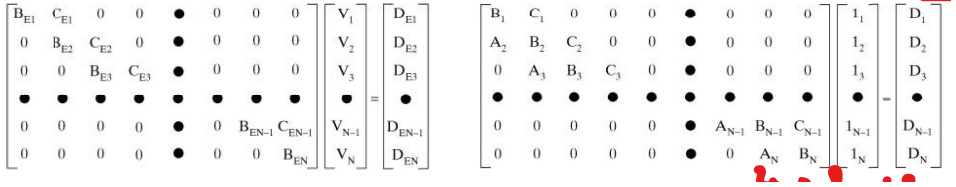

**Função para calcular os valores de V por cascateamento**

Como V2 é conhecido, BE1=0, Vamos usar ele para descobrir V3 e assim por diante

In [97]:
def it2(var,j): 
  Bi = var[0]
  Ci = var[1]
  Di = var[2]

  V = [] # lista contendo o resultado

  #V.append(0) # a primeira vazão é nula
  V.append(D) # a primeira vazão é nula -> inseri D pq ela vira o destilado
  V.append(Di[0]/Ci[0]) # a segunda vazão é essa

  # para o resto até N-1
  u=1 # posição inicial a ser avaliada 

  while u<(j-1): # Vai calcular tudo
    gu = ( Di[u] - (Bi[u])*(V[u]) )/(Ci[u])
    V.append(gu)
    u+=1

  #V.pop(-1)

  d = np.array((V))
  
  return d

In [98]:
V_calc_pinv = it2(var_BEG,j)

In [99]:
V_calc_pinv

array([ 60.        , 180.        , 179.36015324, 178.59460373,
       177.72668004, 176.79919463, 104.0102721 , 102.49880662,
        99.91742383,  96.35493882,  92.98642284,  92.4980637 ])

###**Cálculo de L a partir de V**

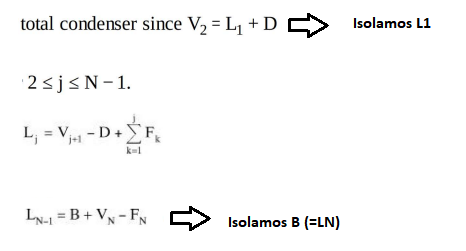

Utilizando a função criada lá no início do programa, usada para calcular L a partir de um chute de V seguindo fluxo molar constante (apenas para o chute)

In [100]:
L_calc = L(D,B,n_alim,V_calc_pinv,F) # aqui era B_att e D_att
L_calc

array([120.        , 119.36015324, 118.59460373, 117.72668004,
       116.79919463, 144.0102721 , 142.49880662, 139.91742383,
       136.35493882, 132.98642284, 132.4980637 ,  40.        ])

###**Erro entre o chute inicial de V/L e o calculado -> critério de parada**

$|(L_{j,new} - L_{j,old})/L_{j,new}| < tol_L$

$|(V_{j,new} - V_{j,old})/V_{j,new}| < tol_V$

In [101]:
tol_L = 10**(-4) # Valor recomendado pelo livro

In [102]:
tol_V = 10**(-4) # Valor recomendado pelo livro

In [103]:
Dif_L = abs(L_calc - L_chute)
Dif_L

array([68.33830018, 67.69845342, 66.93290391, 66.06498022, 65.13749481,
       75.9897279 , 77.50119338, 80.08257617, 83.64506118, 87.01357716,
       87.5019363 ,  0.        ])

In [104]:
Dif_V = abs(V_calc_pinv - V_chute)
Dif_V

array([60.        , 68.33830018, 67.69845342, 66.93290391, 66.06498022,
       65.13749481, 75.9897279 , 77.50119338, 80.08257617, 83.64506118,
       87.01357716, 87.5019363 ])

###**Inserindo o loop para convergência de V e L**

In [105]:
def loop_vaz(L_calc,V_calc,Tb_old,k_old,n_alim,F,j,D,z,P,lista_componentes,dados,erroT,erroV,erroL,hf,q):
 # Tb_old e k_old são os valores obtidos na primeira convergência
 # L_calc e V_calc são os valores obtidos na 1º resolução de matriz
  iteracao = 0 # para verificar depois quantas iterações ele fez
  g = 0 # será atualizado na verificação da tolerância de L
  h = 0 # será atualizado na verificação da tolerância de V
  
  while g!=j and h!=j: # enquanto a verificação de convergencia não bater com a quantida de estágios que devem convergir

    # Grantindo que D vão atualizar após a primeira iteração

    if iteracao == 0:
      D_i = D
      V_calc_i = V_calc
      L_calc_i = L_calc
      k_old_i = k_old
      Tb_old_i = Tb_old
      #hf_i = hf
      
    else:
      D_i = D_att
      V_calc_i = V_calc_att
      L_calc_i = L_calc_att
      k_old_i = k_old_att
      Tb_old_i = Tb_old_att
      #hf_i = hf_att

    # Calculando novos valores de T,X e Y a partir de L e V calculados anteriormente, sendo este o novo chute
    sol_T = loop_T(L_calc_i,V_calc_i,Tb_old_i,k_old_i,n_alim,F,j,D_i,z,P,lista_componentes,dados,erroT)

    # Recuperando os valores desejados de T, x e y
    T_new = sol_T[1] 
    x_new = sol_T[3]
    y_new = sol_T[4]
    erro_T = sol_T[5]
    k_new = sol_T[2]
    

    B_att = F - D
    D_att = D


    H_componentes = f_gera_dados_H(P,j,lista_componentes,dados,x_new,y_new,T_new,0) # o 0 é apenas para indicar um componente para puxar x e y

    H_tot = pd.DataFrame((H_componentes['T'],H_componentes['Hig_v'],H_componentes['Hig_l']),index = ['T','HV','HL']).T


    # Carga térmica do condensador e do refervedor
    hd = H_tot['HL'][0] # entalpias líquidas no condensador [0]
    H2 = H_tot['HV'][1] # entalpias líquidas no topo da coluna [1]
    Q1 = D_att*(1+raz)*(hd - H2) # já tem o valor atualizado

    hb = H_tot['HL'][j-1] # entalpias líquidas da corrente de saída do reboiler
    somat = F*hf
    QN = D_att*hd + B_att*hb - somat - Q1
    print(Q1)
    print(QN)

    # Calculando variáveis da matriz
    var_BEG = variavel_matriz_i_BEG(H_tot,Q1,QN,n_alim,j,D_att,B_att,F,hf)

    V_calc_att = it2(var_BEG,j)

    # Obtendo L
    L_calc_att = L(D_att,B_att,n_alim,V_calc_att,F)
      
      # Cálculo da convergência de V e L:
    Dif_L = abs(L_calc_att - L_calc_i)/L_calc_att
    result_L = Dif_L<erroL # array que retorna True ou False para a condição de ser menor que a tolerância

    Dif_V = abs(V_calc_att - V_calc_i)/V_calc_att
    result_V = Dif_V<erroV

    for i in result_L: # verificando para L
      if i ==False:
        g += 0 
      if i ==True:
        g+=1

    if g!=j:
      g = 0  # Para limpar ele para uma nova iteração

    for i in result_V: # verificando para V
      if i ==False:
        h += 0 
      if i ==True:
        h+=1

    if h!=j:
      h = 0  # Para limpar ele para uma nova iteração

    Tb_old_att = T_new # atualizando o valor para a nova iteração
    k_old_att = k_new  # atualizando o valor para a nova iteração
    iteracao +=1 # atualizando o contador de loops realizados
    print(iteracao)
    
    #print(Tb_old_att[0])

  Tb_final = Tb_old_att
  k_final = k_old_att
  L_final = L_calc_att
  V_final = V_calc_att
  x_final = x_new
  y_final = y_new

  return iteracao,Tb_final,L_final,V_final,x_final,y_final,k_final,Dif_V,Dif_L


###**Resolvendo o nosso loop para encontrarmos V e L, além dos valores atualizados de T, x e y**

In [106]:
k_converg = sol_T[2]

In [107]:
sol_V = loop_vaz(L_calc,V_calc_pinv,T_converg,k_converg,n_alim,F,j,vaz_D,z,P,lista_componentes,dados,tol_T,tol_V,tol_L,hf,q) # L_calc

-5519416.437768876
3266346.205279129
1
-5520015.385779827
3267109.544871652
2
-5520018.607779993
3267115.722682119
3


Os números são a carga da térmica do condensador e do refervedor em sequeência para cada iteração

###**Resgatando os valores obtidos:**

**Número de iterações utilizadas:**

In [108]:
sol_V[0]

3

**Erro encontrado para V e L:**

In [109]:
sol_V[7] #V

array([0.00000000e+00, 0.00000000e+00, 1.57798252e-07, 1.21742517e-06,
       5.59972594e-06, 3.44287326e-06, 4.85282602e-06, 1.77986760e-05,
       3.95594877e-05, 5.34221300e-05, 4.46839871e-05, 2.65280651e-05])

In [110]:
sol_V[8] #L

array([0.00000000e+00, 2.37254485e-07, 1.83765692e-06, 8.50441299e-06,
       5.27236830e-06, 3.49976744e-06, 1.27754117e-05, 2.81934823e-05,
       3.77334858e-05, 3.13056447e-05, 1.85600496e-05, 0.00000000e+00])

**Perfil de temperatura:**

In [111]:
T_final = sol_V[1]
T_final

[353.9470150654115,
 354.7121371547951,
 355.97902175579867,
 358.0386254343884,
 361.3603931938445,
 366.58298678921807,
 368.8542931794028,
 372.2856627615759,
 376.7257993631791,
 381.6999931767089,
 386.9877175912266,
 392.9754799350679]

**x em cada estágio:**

In [112]:
x_final = sol_V[4]
x_final

[[0.651775648596366,
  0.6232463232625851,
  0.5822582757765141,
  0.5238978050812618,
  0.44504885430147545,
  0.3487822402974304,
  0.3008014121714364,
  0.23640415868655015,
  0.1650257287021723,
  0.10075945280050494,
  0.05275156153435595,
  0.02233129239604468],
 [0.3240068543582256,
  0.3160161604928107,
  0.2993274342603494,
  0.27195722484982904,
  0.2326412148537003,
  0.18322903679933988,
  0.16192513387944696,
  0.13063976076624373,
  0.09381136773602268,
  0.05903810705899383,
  0.031916928771303296,
  0.013987140215516738],
 [0.023987566003124065,
  0.05933245804754331,
  0.11252227934916989,
  0.18267470287695847,
  0.2544488991461801,
  0.29212952466690384,
  0.35183526265511567,
  0.43158872481931526,
  0.5135867084088083,
  0.5668712535048231,
  0.5580381908733145,
  0.46402231049911835],
 [0.00022993104228421644,
  0.0014050581970608388,
  0.005892010613966609,
  0.021470267191950797,
  0.06786103169864431,
  0.17585919823632581,
  0.18543819129400105,
  0.2013673557

**y em cada estágio:**

In [113]:
y_final = sol_V[5]
y_final

[[0.6658477778841093,
  0.651775658732859,
  0.6328007308983551,
  0.6057211468469386,
  0.5675750026297748,
  0.5167846876365461,
  0.47500002333160135,
  0.4103071008432852,
  0.3227172323133537,
  0.22436028626451285,
  0.13427687738815103,
  0.0658112189042516],
 [0.324668592603384,
  0.3240068308745874,
  0.31869219008708466,
  0.3076570321482061,
  0.2897352124540034,
  0.2643460184817302,
  0.24866424264295084,
  0.22010033683466432,
  0.177673317296227,
  0.12700329907886387,
  0.07829117956344625,
  0.03961428375627641],
 [0.009447082583196431,
  0.02398757909814596,
  0.04749556681248191,
  0.08264082666085744,
  0.12847431170795862,
  0.1744769604108099,
  0.225669218286,
  0.30771874254254794,
  0.41851263113647735,
  0.5341983529799917,
  0.6108269889967566,
  0.5984006966945853],
 [3.654692931050179e-05,
  0.0002299312944091282,
  0.0010115122038355806,
  0.003980994344365603,
  0.014215473208284183,
  0.0443923334709129,
  0.050666515739447,
  0.06187381978009131,
  0.08

**Valores de V em cada estágio**

In [114]:
V_final = sol_V[3]
V_final

array([ 60.        , 180.        , 179.15862073, 177.77131632,
       175.66945112, 172.91224697, 103.46240684, 101.72995849,
        99.22037295,  96.20585493,  93.6009678 ,  93.17275775])

**Valores de L em cada estágio**

In [115]:
L_final = sol_V[2]
L_final

array([120.        , 119.15862073, 117.77131632, 115.66945112,
       112.91224697, 143.46240684, 141.72995849, 139.22037295,
       136.20585493, 133.6009678 , 133.17275775,  40.        ])

### **Itens auxiliares dos gráficos e tabelas**

####**Nomes das colunas do dataframe e eixo x dos gráficos**

É necessário criar o nome das colunas de forma automática para estes serem inseridos no dataframe final, de forma que contenha também o estágio da alimentação

In [116]:
colunas = []

colunas.append('condensador')
colunas.append('2-topo')

rotulo = 3 # o primeiro que será incluído, a menos que ele seja a alimentação

while rotulo < n_alim+1: # pegando cada um dos estágios
  colunas.append(rotulo)
  rotulo += 1

colunas.append('alimentação')
rotulo += 1

while rotulo < j-1: # pegando cada um dos estágios
  colunas.append(rotulo)
  rotulo += 1

colunas.append('fundo')
colunas.append('refervedor')


####**Index do dataframe**

In [117]:
nome_componente

['Benzeno', 'Ciclo-hexano', 'Tolueno', 'p-xileno']

In [118]:
linhas = []

for i in nome_componente:
  a = 'x_' + i
  linhas.append(a)
  
for i in nome_componente:
  a = 'y_' + i
  linhas.append(a)

linhas.append('V [kg/s]')
linhas.append('L [kg/s]')
linhas.append('T [K]')

linhas

['x_Benzeno',
 'x_Ciclo-hexano',
 'x_Tolueno',
 'x_p-xileno',
 'y_Benzeno',
 'y_Ciclo-hexano',
 'y_Tolueno',
 'y_p-xileno',
 'V [kg/s]',
 'L [kg/s]',
 'T [K]']

####**vetor com os dados do dataframe**

In [119]:
# criando o vetor que contém x, y, V, L e T

vetor_dados = []
n_componentes = len(x_final)

# fazer um append geral de tudo

cont = 0

while cont != n_componentes:
  vetor_dados.append(x_final[cont]) # inserindo x
  cont +=1

cont = 0

while cont != n_componentes:
  vetor_dados.append(y_final[cont]) # inserindo y
  cont +=1

vetor_dados.append(V_final) # inserindo vazão de vapor
vetor_dados.append(L_final) # inserindo vazão de líquido
vetor_dados.append(T_final) # inserindo temperatura

#vetor_dados


###**Criando as visualizações do resultado**

In [120]:
Resultado_final = pd.DataFrame(vetor_dados, columns=colunas,index=linhas)

In [121]:
x1D_final = x_final[0][0] # valor no topo
x1B_final = x_final[0][j-1]     # valor complementar ao topo
v_resul_final = np.array([z[0]*F,F])
A_bmg_final = np.array([[x1B_final,x1D_final],
                  [1,1]])
x_sol_bmg_final = np.linalg.inv(A_bmg_final) @ v_resul_final

B_final = x_sol_bmg_final[0]
D_final = x_sol_bmg_final[1]

In [122]:
x_eixo = colunas

# **Resultados**

###**DataFrame com os dados finais**


In [123]:
Resultado_final

,condensador,2-topo,3,4,5,alimentação,7,8,9,10,fundo,refervedor
x_Benzeno,0.651776,0.623246,0.582258,0.523898,0.445049,0.348782,0.300801,0.236404,0.165026,0.100759,0.052752,0.022331
x_Ciclo-hexano,0.324007,0.316016,0.299327,0.271957,0.232641,0.183229,0.161925,0.130640,0.093811,0.059038,0.031917,0.013987
x_Tolueno,0.023988,0.059332,0.112522,0.182675,0.254449,0.292130,0.351835,0.431589,0.513587,0.566871,0.558038,0.464022
x_p-xileno,0.000230,0.001405,0.005892,0.021470,0.067861,0.175859,0.185438,0.201367,0.227576,0.273331,0.357293,0.499659
y_Benzeno,0.665848,0.651776,0.632801,0.605721,0.567575,0.516785,0.475000,0.410307,0.322717,0.224360,0.134277,0.065811
y_Ciclo-hexano,0.324669,0.324007,0.318692,0.307657,0.289735,0.264346,0.248664,0.220100,0.177673,0.127003,0.078291,0.039614
y_Tolueno,0.009447,0.023988,0.047496,0.082641,0.128474,0.174477,0.225669,0.307719,0.418513,0.534198,0.610827,0.598401
y_p-xileno,0.000037,0.000230,0.001012,0.003981,0.014215,0.044392,0.050667,0.061874,0.081097,0.114438,0.176605,0.296174
V [kg/s],60.000000,180.000000,179.158621,177.771316,175.669451,172.912247,103.462407,101.729958,99.220373,96.205855,93.600968,93.172758
L [kg/s],120.000000,119.158621,117.771316,115.669451,112.912247,143.462407,141.729958,139.220373,136.205855,133.600968,133.172758,40.000000


###**valores finais de D e B a partir do valor final de x e y**

In [124]:
B_final

39.999667344104054

In [128]:
D_final

60.00033265589594

##**Gráficos**

###**Fração molar de líquido na torre de destilação**

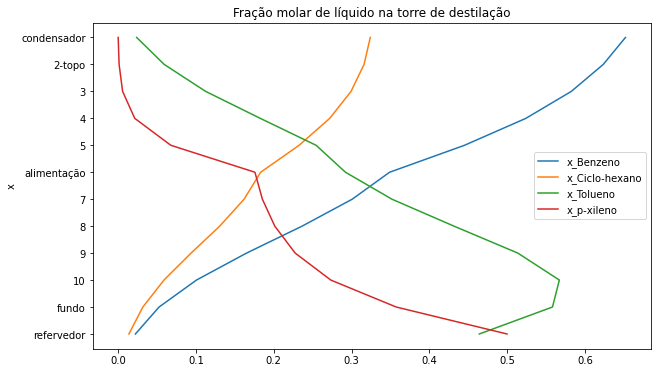

In [129]:
# Fazendo o gráfico
fig9, ax9 = plt.subplots(figsize =(10,6))

fg = 0

while fg != n_componentes:

  ax9.plot( x_final[fg],x_eixo, label='x_' + nome_componente[fg])
  fg+=1

# Adicionando texto nos eixos - descrição
ax9.set_ylabel('x')
ax9.invert_yaxis() 
# Adicionando título para a figura
ax9.set_title('Fração molar de líquido na torre de destilação')

# Adicionando uma legenda
ax9.legend()

###**Fração molar de vapor na torre de destilação**

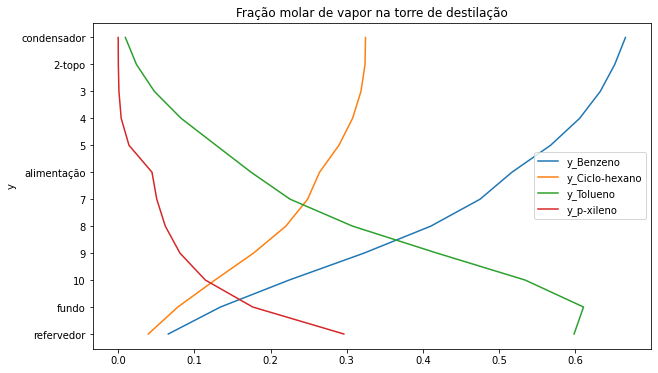

In [130]:
# Fazendo o gráfico
fig91, ax91 = plt.subplots(figsize =(10,6))

fg = 0

while fg != n_componentes:

  ax91.plot( y_final[fg],x_eixo, label='y_' + nome_componente[fg])
  fg+=1

# Adicionando texto nos eixos - descrição
ax91.set_ylabel('y')
ax91.invert_yaxis() 
# Adicionando título para a figura
ax91.set_title('Fração molar de vapor na torre de destilação')

# Adicionando uma legenda
ax91.legend()

###**Vazões**

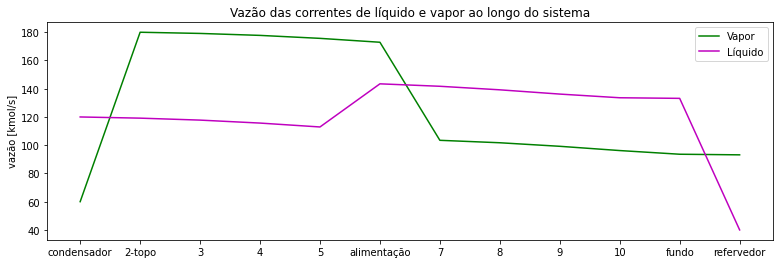

In [131]:
fig3, ax3 = plt.subplots(figsize =(13,4))
ax3.plot( x_eixo,V_final, 'g', label='Vapor')
ax3.plot( x_eixo,L_final, 'm', label='Líquido')

# Adicionando texto nos eixos - descrição
ax3.set_ylabel('vazão [kmol/s]')
# Adicionando título para a figura
ax3.set_title('Vazão das correntes de líquido e vapor ao longo do sistema')
# Adicionando uma legenda
ax3.legend()

###**Perfil de Temperatura**

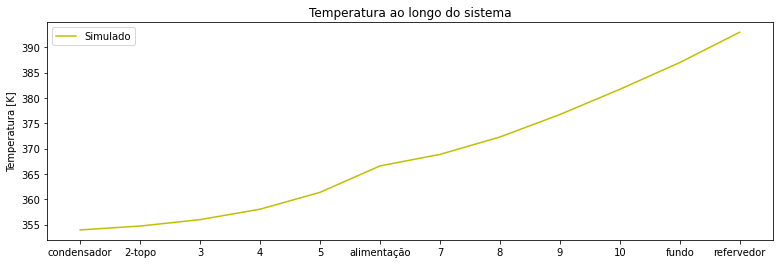

In [132]:
fig4, ax4 = plt.subplots(figsize =(13,4))
ax4.plot(x_eixo,T_final, 'y',label="Simulado")

# Adicionando texto nos eixos - descrição
ax4.set_ylabel('Temperatura [K]')
# Adicionando título para a figura
ax4.set_title('Temperatura ao longo do sistema')

# Adicionando uma legenda
ax4.legend()

#**Gráficos - validação**

**Apenas para fins validação dos dados utilizados como exemplo nesse simulador, os dados de validação foram obtidos no ChemSep e inseridos manualmente aqui**

In [133]:
x_eixo = colunas

In [134]:
# Dados da validação

x_val_benzeno = [0.651109,0.621073,0.57802,0.517484,0.43763,0.34334,0.298136,0.236967,0.167729,0.103647,0.0546844,0.0233366]
x_val_tolueno = [0.0252451,0.0624921,0.118143,0.190258,0.261459,0.295006,0.351767,0.428928,0.51052,0.565255,0.557039,0.462132]
x_val_xileno = [0.00026389,0.00158597,0.00653015,0.0232623,0.0716177,0.180702,0.188746,0.202133,0.225393,0.269533,0.354617,0.499604]
x_val_ciclo_hexano = [0.323382,0.314849,0.297307,0.268996,0.229293,0.180952,0.161352,0.131972,0.096357,0.0615651,0.0336593,0.014927]

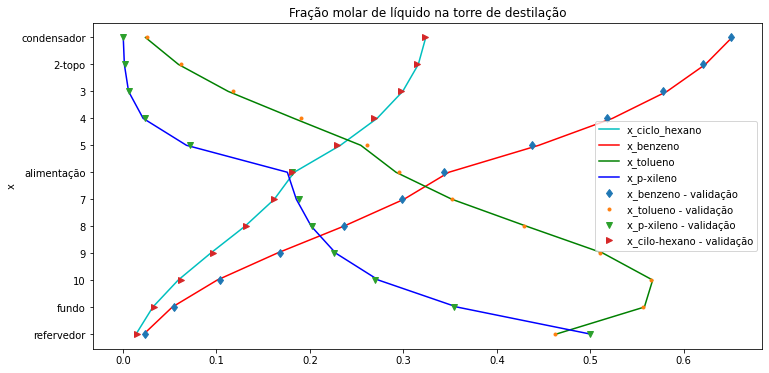

In [135]:
# Fazendo o gráfico
fig9, ax9 = plt.subplots(figsize =(12,6))
ax9.plot( x_final[1],x_eixo, 'c', label='x_ciclo_hexano')
ax9.plot( x_final[0],x_eixo, 'r', label='x_benzeno')
ax9.plot( x_final[2],x_eixo, 'g', label='x_tolueno')
ax9.plot( x_final[3],x_eixo, 'b', label='x_p-xileno')


ax9.plot( x_val_benzeno,x_eixo, 'd', label='x_benzeno - validação')
ax9.plot( x_val_tolueno,x_eixo, '.', label='x_tolueno - validação')
ax9.plot( x_val_xileno,x_eixo, 'v', label='x_p-xileno - validação')
ax9.plot( x_val_ciclo_hexano,x_eixo, '>', label='x_cilo-hexano - validação')
# Adicionando texto nos eixos - descrição
ax9.set_ylabel('x')
ax9.invert_yaxis() 
# Adicionando título para a figura
ax9.set_title('Fração molar de líquido na torre de destilação')
# Adicionando linha
#ax9.vlines(5,0.0, 1, colors='r', linestyles='dashed')
# Adicionando uma legenda
ax9.legend()

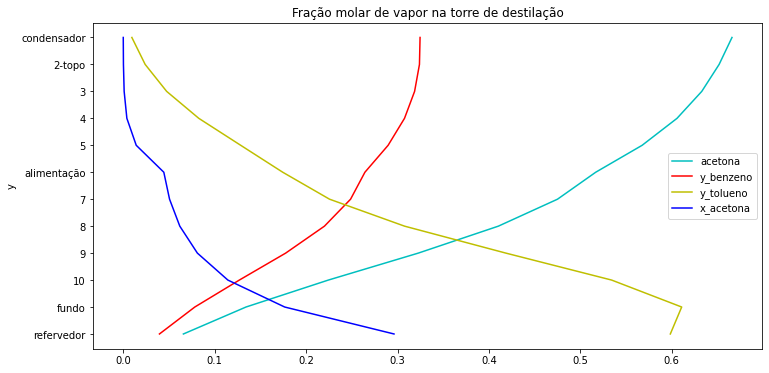

In [136]:
# Fazendo o gráfico
fig2, ax2 = plt.subplots(figsize =(12,6))
ax2.plot( y_final[0],x_eixo, 'c', label='acetona')
ax2.plot( y_final[1],x_eixo, 'r', label='y_benzeno')
ax2.plot( y_final[2],x_eixo, 'y', label='y_tolueno')
ax2.plot( y_final[3],x_eixo, 'b', label='x_acetona')

# Adicionando texto nos eixos - descrição
ax2.set_ylabel('y')
ax2.invert_yaxis() 
# Adicionando título para a figura
ax2.set_title('Fração molar de vapor na torre de destilação')
# Adicionando linha
# Adicionando uma legenda
ax2.legend()


In [137]:
nome_componente

['Benzeno', 'Ciclo-hexano', 'Tolueno', 'p-xileno']

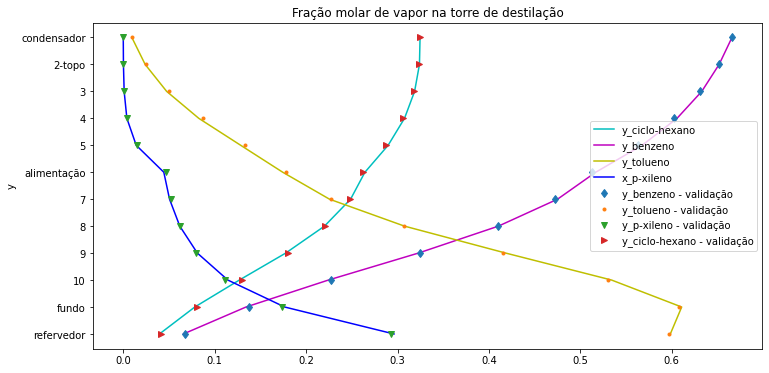

In [138]:
y_val_benzeno = [0.665842,0.651109,0.631142,0.602749,0.563359,0.512565,0.472158,0.409767,0.32464,0.227536,0.137197,0.0679282]
y_val_tolueno = [0.00991187,0.0252451,0.0500053,0.0867115,0.133607,0.178543,0.227729,0.306934,0.415301,0.530562,0.608334,0.597136]
y_val_xileno = [0.0000425766,0.00026389,0.00114275,0.00440997,0.0153667,0.046571,0.0523274,0.0624668,0.0800515,0.111816,0.173421,0.293363]
y_val_hexano = [0.324204,0.323382,0.31771,0.306129,0.287667,0.26232,0.247786,0.220833,0.180007,0.130085,0.0810481,0.0415733]

# Fazendo o gráfico
fig2, ax2 = plt.subplots(figsize =(12,6))
ax2.plot( y_final[1],x_eixo, 'c', label='y_ciclo-hexano')
ax2.plot( y_final[0],x_eixo, 'm', label='y_benzeno')
ax2.plot( y_final[2],x_eixo, 'y', label='y_tolueno')
ax2.plot( y_final[3],x_eixo, 'b', label='x_p-xileno')

ax2.plot( y_val_benzeno,x_eixo, 'd', label='y_benzeno - validação')
ax2.plot( y_val_tolueno,x_eixo, '.', label='y_tolueno - validação')
ax2.plot( y_val_xileno,x_eixo, 'v', label='y_p-xileno - validação')
ax2.plot( y_val_hexano,x_eixo, '>', label='y_ciclo-hexano - validação')
# Adicionando texto nos eixos - descrição
ax2.set_ylabel('y')
ax2.invert_yaxis() 
# Adicionando título para a figura
ax2.set_title('Fração molar de vapor na torre de destilação')
# Adicionando linha
# Adicionando uma legenda
ax2.legend()


In [139]:
vapor_validacao = [0.6,1.8,1.78975,1.773319,1.747688,1.709301,0.993657,0.984672,0.974661,0.965725,0.957515,0.946797]
liquido_validacao = [1.2,1.18975,1.173319,1.147688,1.109301,1.393657,1.384672,1.374661,1.365725,1.357515,1.346798,0.4]

v_val = []
l_val = []

for i in vapor_validacao:
  v_val.append(i*100)

for i in liquido_validacao:
  l_val.append(i*100) 

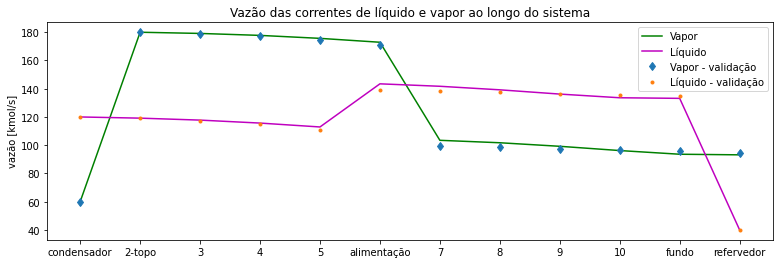

In [140]:
# Fazendo o gráfico
fig3, ax3 = plt.subplots(figsize =(13,4))
ax3.plot( x_eixo,V_final, 'g', label='Vapor')
ax3.plot( x_eixo,L_final, 'm', label='Líquido')

ax3.plot( x_eixo,v_val, 'd', label='Vapor - validação')
ax3.plot( x_eixo,l_val, '.', label='Líquido - validação')


# Adicionando texto nos eixos - descrição
ax3.set_ylabel('vazão [kmol/s]')
# Adicionando título para a figura
ax3.set_title('Vazão das correntes de líquido e vapor ao longo do sistema')
# Adicionando uma legenda
ax3.legend()

In [141]:
T_validacao = [354.03,354.85,356.2,358.36,361.77,366.96,369.07,372.27,376.46,381.28,386.54,392.58]


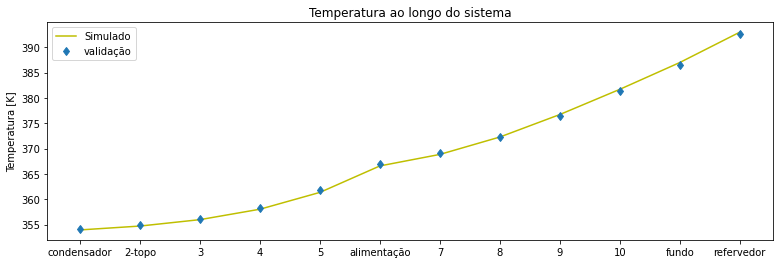

In [142]:
# Fazendo o gráfico
fig4, ax4 = plt.subplots(figsize =(13,4))
ax4.plot(x_eixo,T_final, 'y',label="Simulado")
ax4.plot(x_eixo,T_validacao, 'd',label="validação")
# Adicionando texto nos eixos - descrição
ax4.set_ylabel('Temperatura [K]')
# Adicionando título para a figura
ax4.set_title('Temperatura ao longo do sistema')
# Adicionando linha
# Adicionando uma legenda
ax4.legend()